In [1]:
import xarray as xr
import dask
import numpy as np
import act.io.armfiles
import cmweather
import sys
%pip install cmweather
import siphon
from siphon.catalog import TDSCatalog

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
import netCDF4
import pyart
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
from matplotlib.dates import DateFormatter


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
from pyart.testing import get_test_data
import fsspec
from metpy.plots import USCOUNTIES
import warnings
warnings.filterwarnings("ignore")
import glob
import os
import cmap

In [4]:
ds = xr.open_mfdataset('/nfs/gce/projects/crocus/data/early_in_project_ingested_data/neiu-mrrpro/processed/202401/20240109/*.nc')
ds['range_spectra'] = (['n_spectra'], ds['range'].values)
ds = ds.set_coords(['range_spectra'])

In [5]:
ds

<xarray.Dataset>
Dimensions:                       (time: 8280, range: 128,
                                   spectrum_n_samples_extended: 192,
                                   spectrum_n_samples: 64, n_spectra: 128)
Coordinates:
  * range                         (range) float32 0.0 35.0 ... 4.445e+03
  * time                          (time) datetime64[ns] 2024-01-09T00:00:00.0...
    elevation                     (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    azimuth                       (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    range_spectra                 (n_spectra) float32 0.0 35.0 ... 4.445e+03
Dimensions without coordinates: spectrum_n_samples_extended,
                                spectrum_n_samples, n_spectra
Data variables:
    spectrum_reflectivity         (time, range, spectrum_n_samples_extended) float64 dask.array<chunksize=(1, 128, 192), meta=np.ndarray>
    Zea                           (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    VEL                           (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    WIDTH                         (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    SNR                           (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    noise_level                   (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    noise_floor                   (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    flag_spectrum_reconstruction  (time, range, spectrum_n_samples) float64 dask.array<chunksize=(1, 128, 64), meta=np.ndarray>
Attributes:
    Conventions:      CF/Radial
    version:          1.3
    title:            METEK MRR Pro 1.2.5 Data - Re-processed with ASPRO
    institution:      
    references:       
    source:           
    history:          Re-processed with ASPRO on 25/03/2024 19:30:32 UTC
    comment:          
    instrument_name:  METEK MRR Pro 1.2.5, ID: MRRPro97, METEK Serial Number:...
    site_name:        cms-mrr-002
    field_names:      spectrum_reflectivity,Zea,VEL,WIDTH,SNR,noise_level,noi...

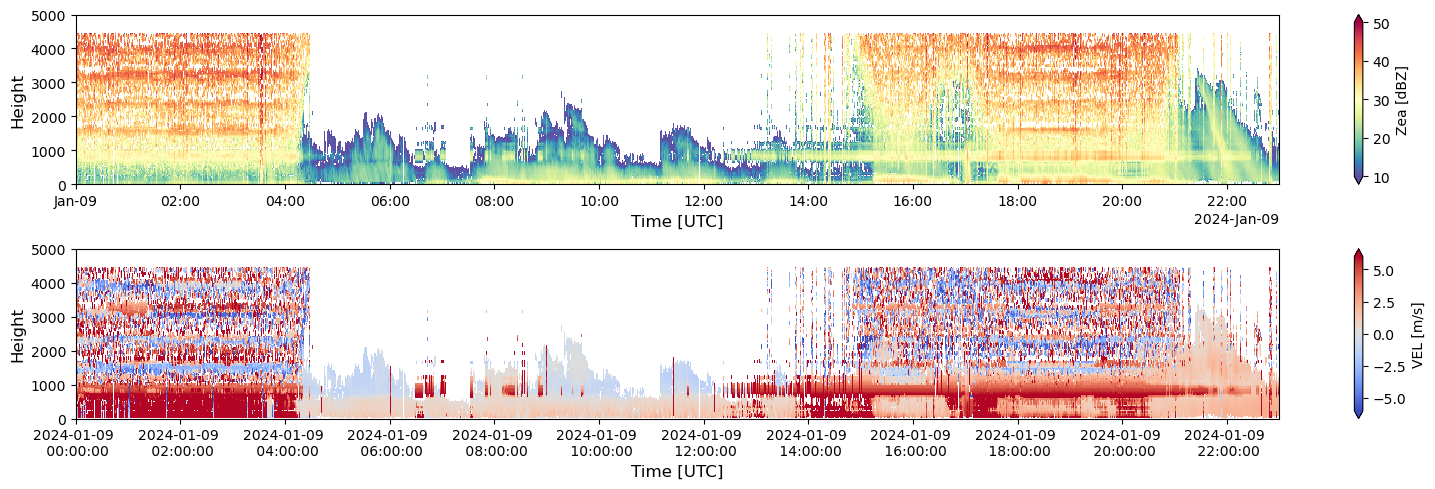

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(16, 5))
ds["Zea"].T.plot(cmap='Spectral_r', vmin=10, vmax=50, ax=ax[0])
ax[0].set_xlabel('Time [UTC]', fontsize=12), ax[0].set_ylabel('Height', fontsize=12)
ax[0].set_ylim(0, 5000)
ds["VEL"].T.plot(cmap='coolwarm', vmin=-6, vmax=6, ax=ax[1])
ax[1].set_xlabel('Time [UTC]', fontsize=12), ax[1].set_ylabel('Height', fontsize=12)
ax[1].set_ylim(0, 5000)
date_form = DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)
fig.tight_layout()
#plt.savefig('January 9th Processed 2.png', dpi=300, bbox_inches='tight')

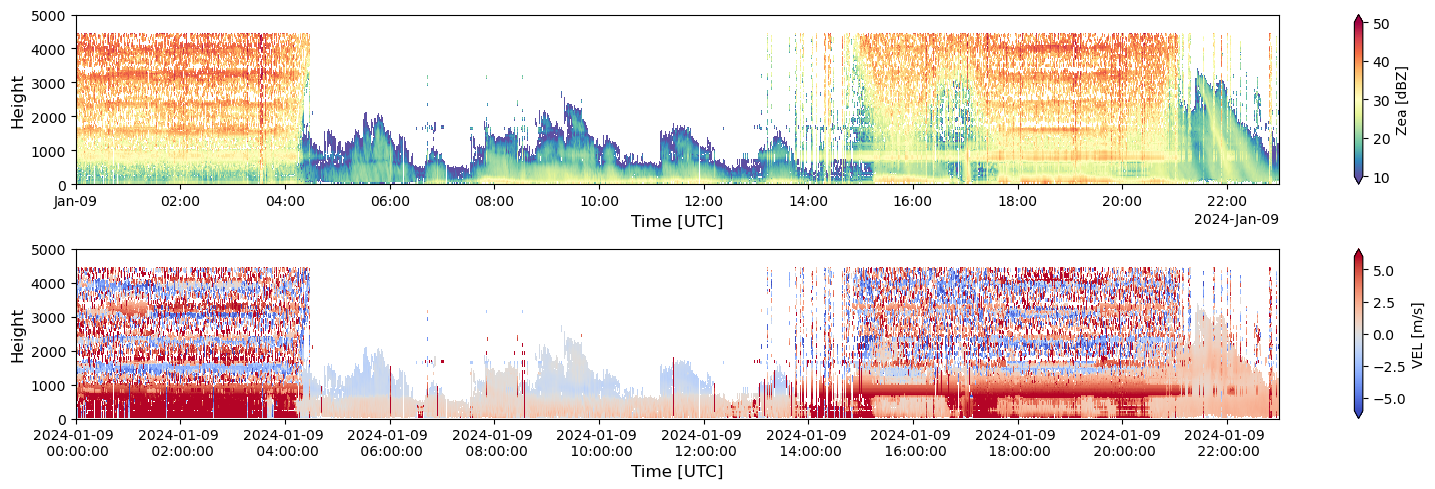

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(16, 5))
ds["Zea"].T.plot(cmap='Spectral_r', vmin=10, vmax=50, ax=ax[0])
ax[0].set_xlabel('Time [UTC]', fontsize=12), ax[0].set_ylabel('Height', fontsize=12)
ax[0].set_ylim(0, 5000)
ds["VEL"].T.plot(cmap='coolwarm', vmin=-6, vmax=6, ax=ax[1])
ax[1].set_xlabel('Time [UTC]', fontsize=12), ax[1].set_ylabel('Height', fontsize=12)
ax[1].set_ylim(0, 5000)
date_form = DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)
fig.tight_layout()
plt.savefig('January 9th Processed 3.png', dpi=300, bbox_inches='tight')

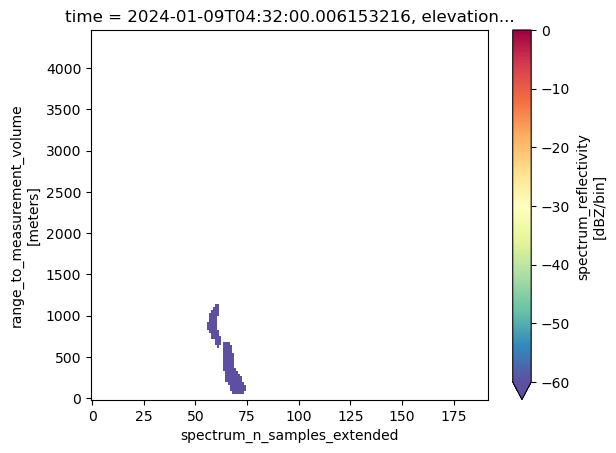

In [107]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T04:32:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)

In [11]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])

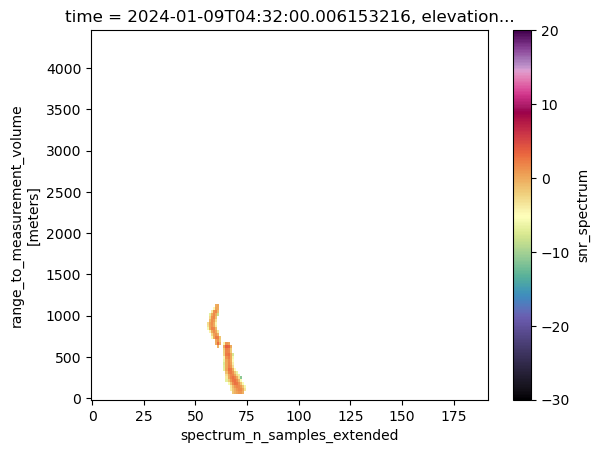

In [12]:
ds['snr_spectrum'].sel(time='2024-01-09T4:32:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)

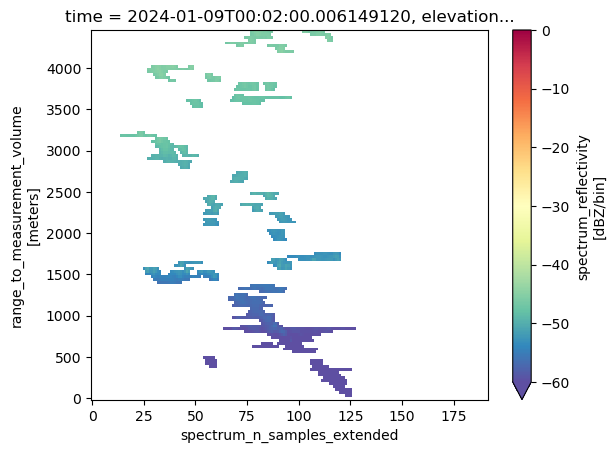

In [167]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T00:02:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.000200.png', dpi=300, bbox_inches='tight')

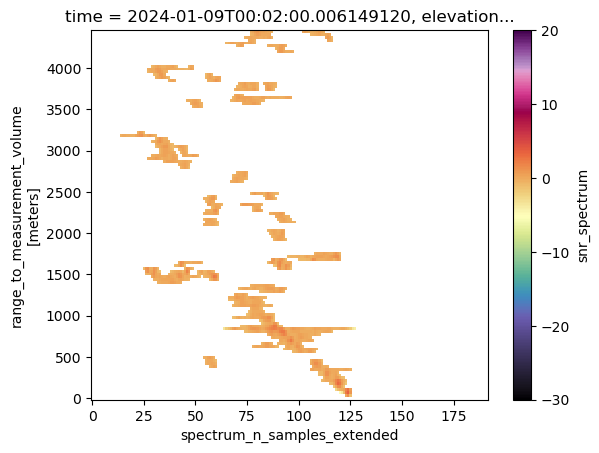

In [168]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T00:02:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.000200.snr.png', dpi=300, bbox_inches='tight')

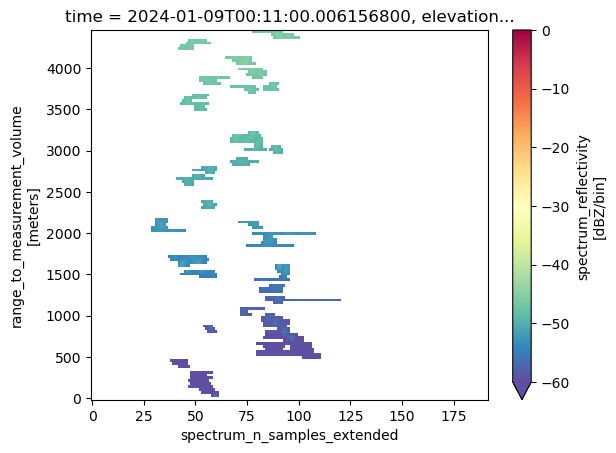

In [169]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T00:11:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.001100.png', dpi=300, bbox_inches='tight')

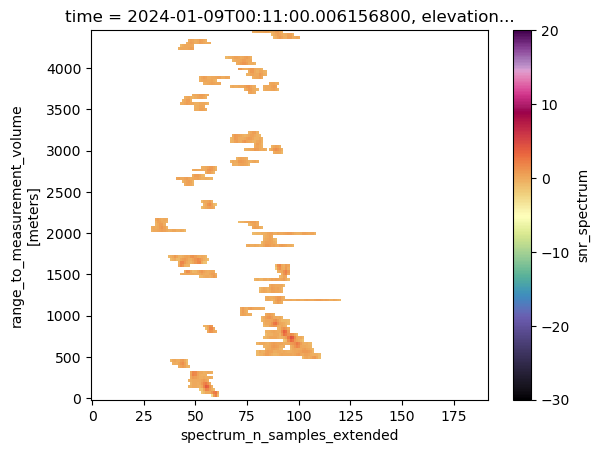

In [170]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T00:11:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.001100.snr.png', dpi=300, bbox_inches='tight')

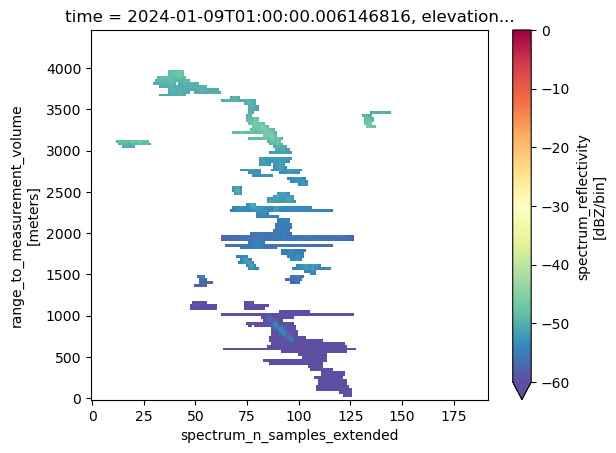

In [171]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T01:00:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.010000.png', dpi=300, bbox_inches='tight')

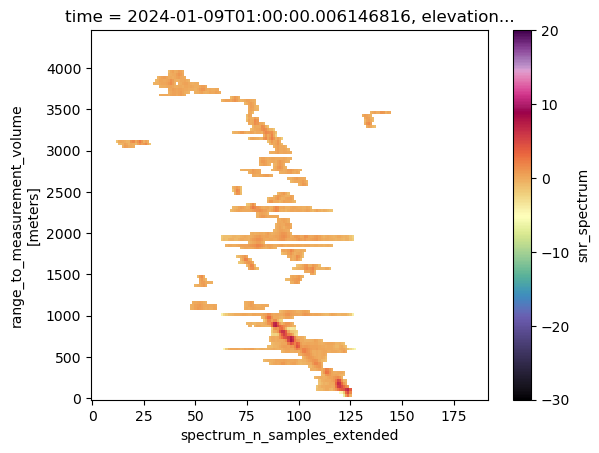

In [172]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T01:00:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.010000.snr.png', dpi=300, bbox_inches='tight')

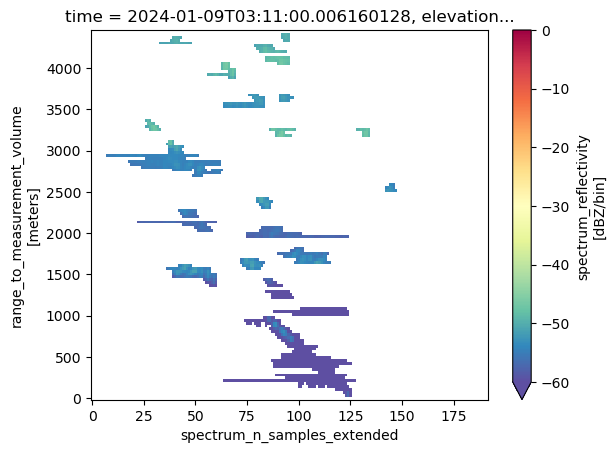

In [173]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T03:11:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.031100.png', dpi=300, bbox_inches='tight')

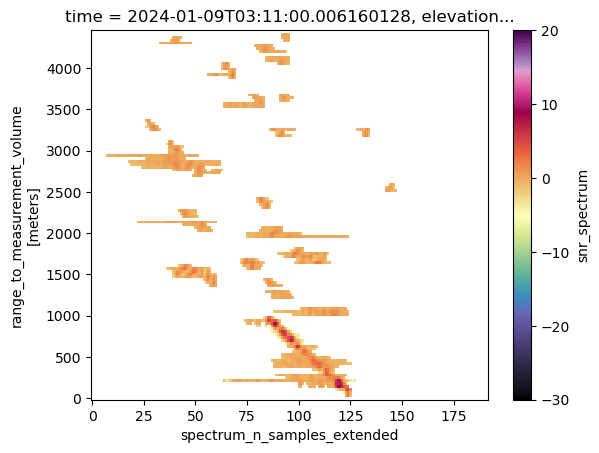

In [174]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T03:11:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.031100.snr.png', dpi=300, bbox_inches='tight')

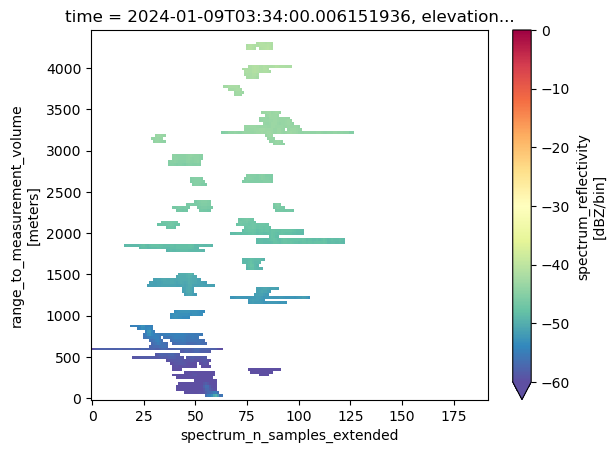

In [175]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T03:34:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.033400.png', dpi=300, bbox_inches='tight')

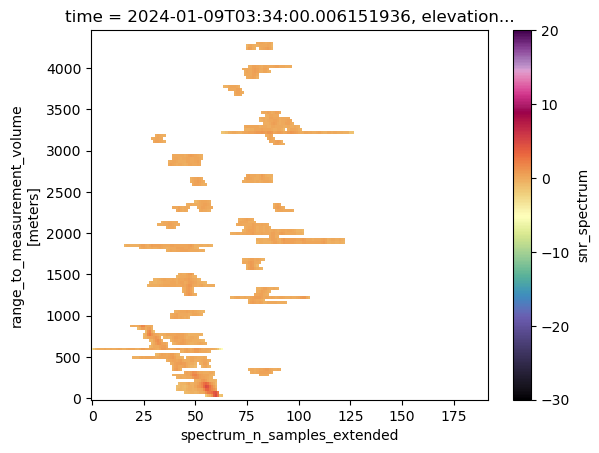

In [176]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T03:34:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.033400.snr.png', dpi=300, bbox_inches='tight')

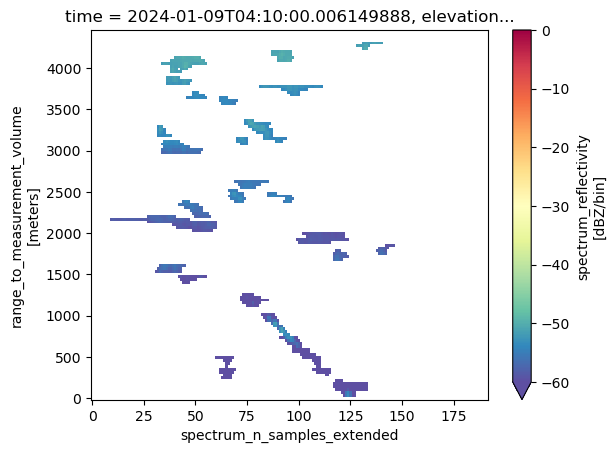

In [177]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T04:10:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.041000.png', dpi=300, bbox_inches='tight')

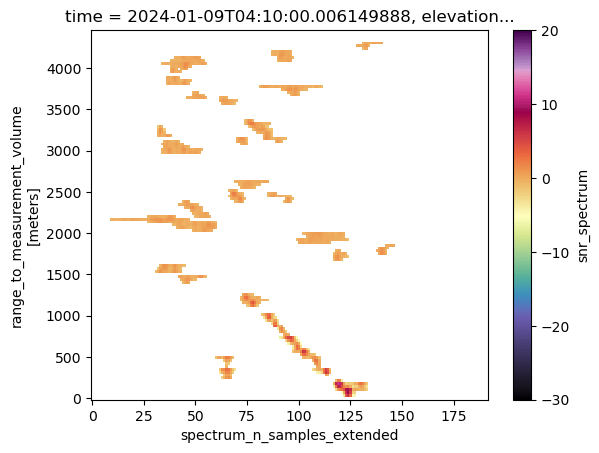

In [178]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T04:10:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.041000.snr.png', dpi=300, bbox_inches='tight')

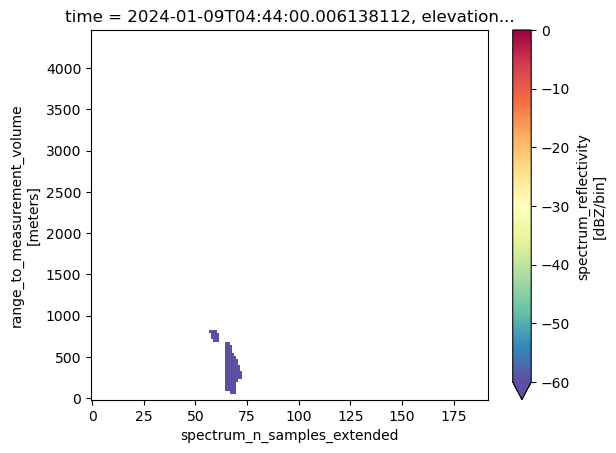

In [179]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T04:44:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.044400.png', dpi=300, bbox_inches='tight')

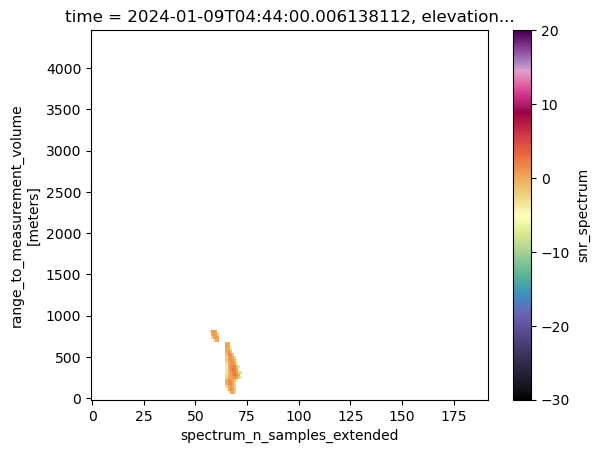

In [180]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T04:44:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.044400.snr.png', dpi=300, bbox_inches='tight')

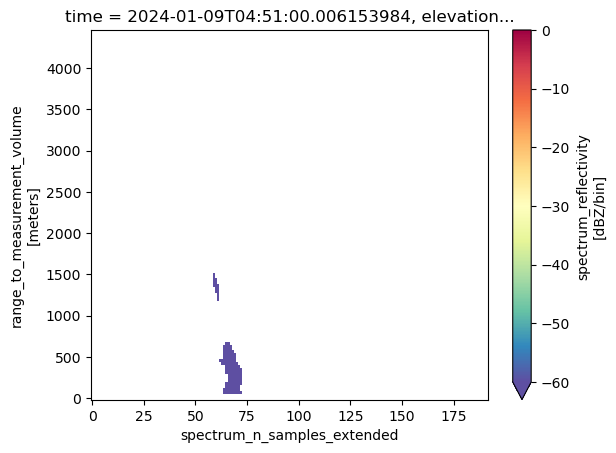

In [181]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T04:51:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.045100.png', dpi=300, bbox_inches='tight')

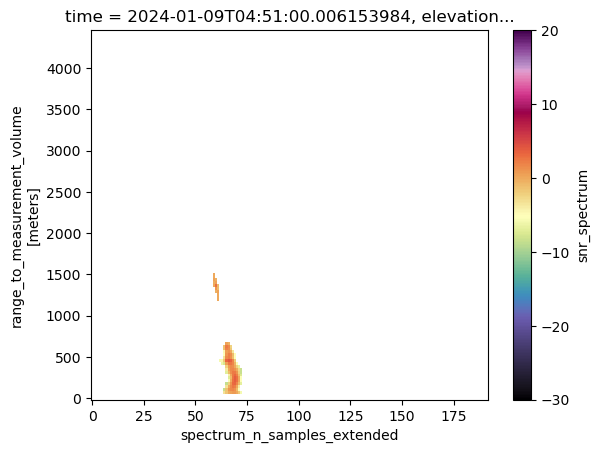

In [182]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T04:51:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.045100.snr.png', dpi=300, bbox_inches='tight')

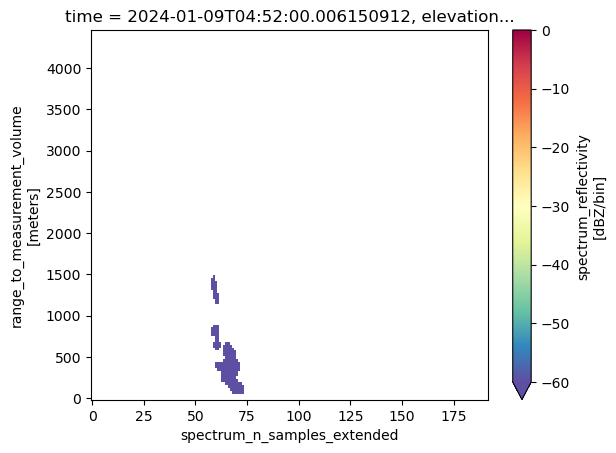

In [183]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T04:52:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.045200.png', dpi=300, bbox_inches='tight')

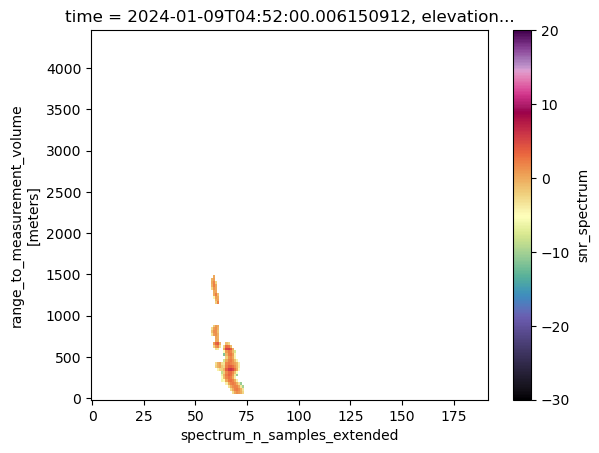

In [184]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T04:52:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.045200.snr.png', dpi=300, bbox_inches='tight')

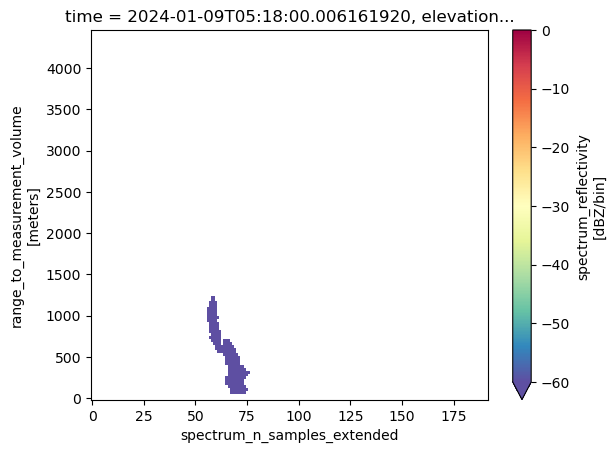

In [185]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T05:18:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.051800.png', dpi=300, bbox_inches='tight')

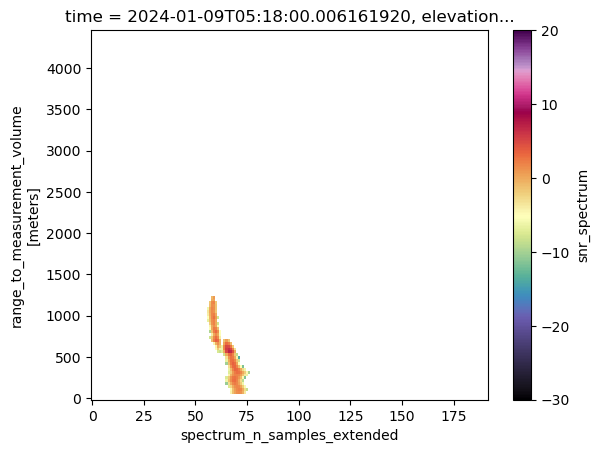

In [186]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T05:18:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.051800.snr.png', dpi=300, bbox_inches='tight')

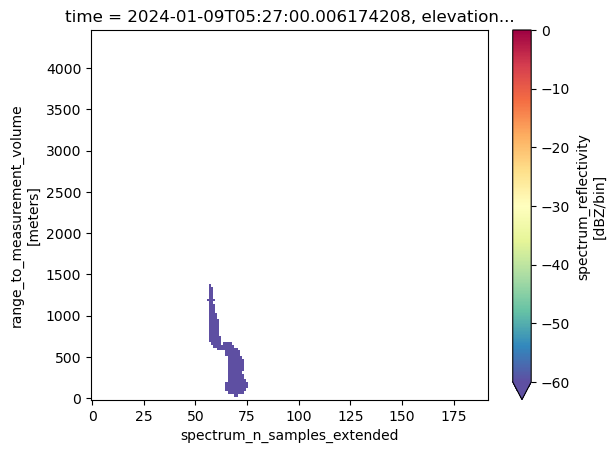

In [187]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T05:27:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.052700.png', dpi=300, bbox_inches='tight')

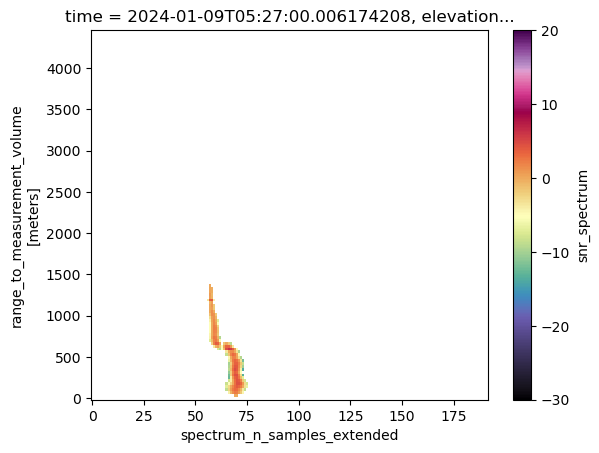

In [188]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T05:27:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.052700.snr.png', dpi=300, bbox_inches='tight')

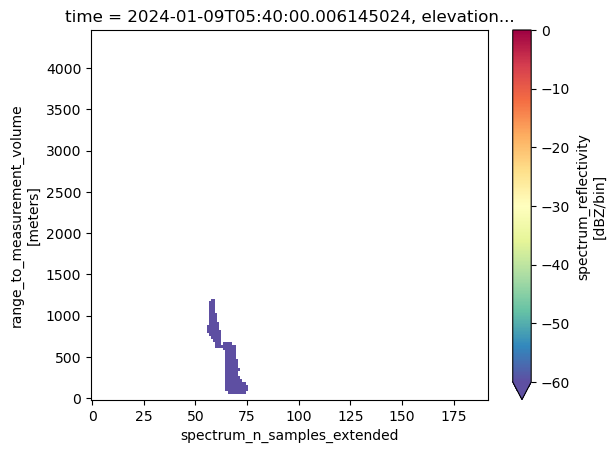

In [189]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T05:40:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.054000.png', dpi=300, bbox_inches='tight')

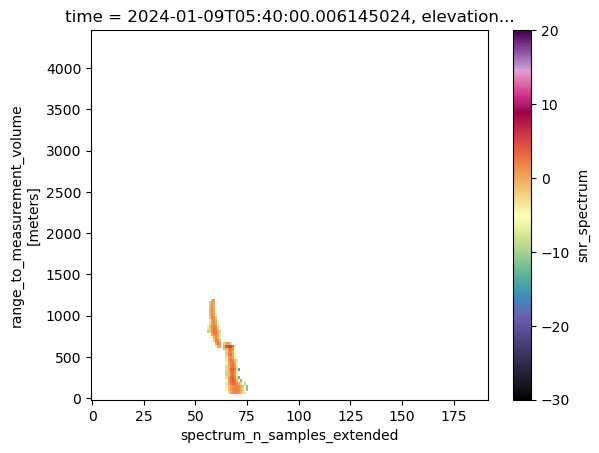

In [190]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T05:40:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.054000.snr.png', dpi=300, bbox_inches='tight')

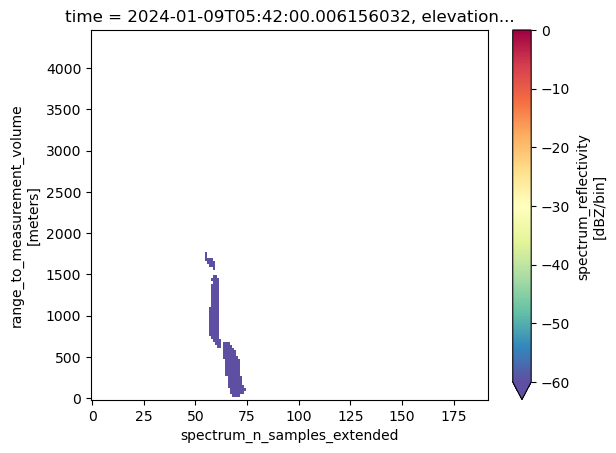

In [191]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T05:42:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.054200.png', dpi=300, bbox_inches='tight')

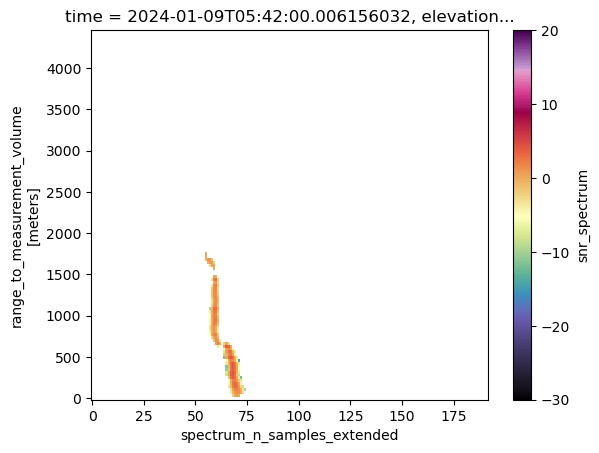

In [192]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T05:42:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.054200.snr.png', dpi=300, bbox_inches='tight')

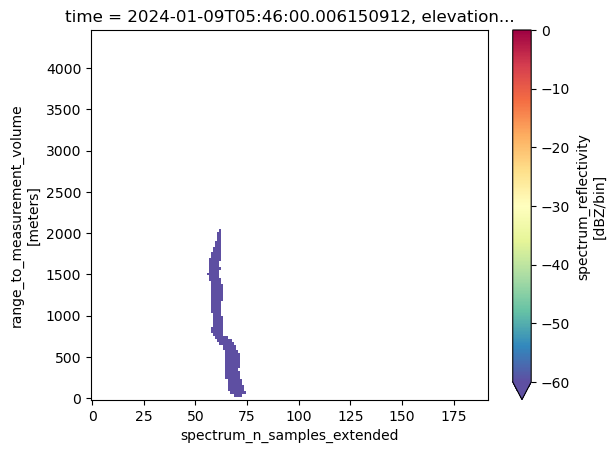

In [193]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T05:46:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.054600.png', dpi=300, bbox_inches='tight')

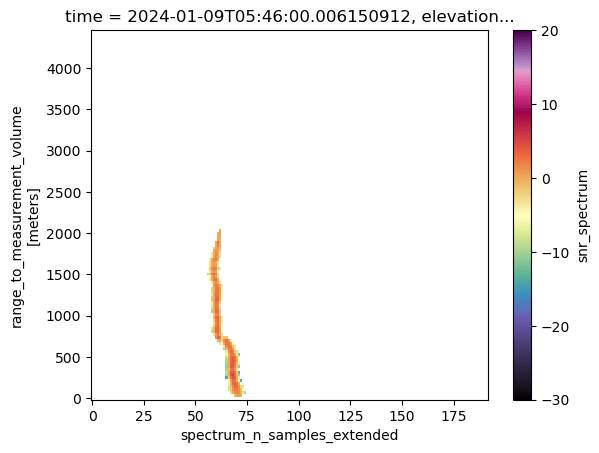

In [194]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T05:46:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.054600.snr.png', dpi=300, bbox_inches='tight')

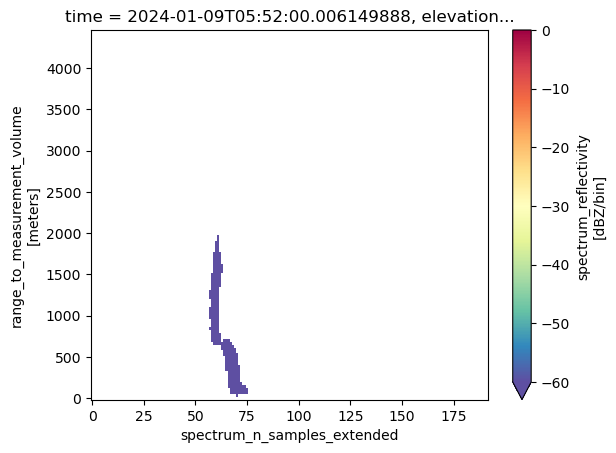

In [195]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T05:52:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.055200.png', dpi=300, bbox_inches='tight')

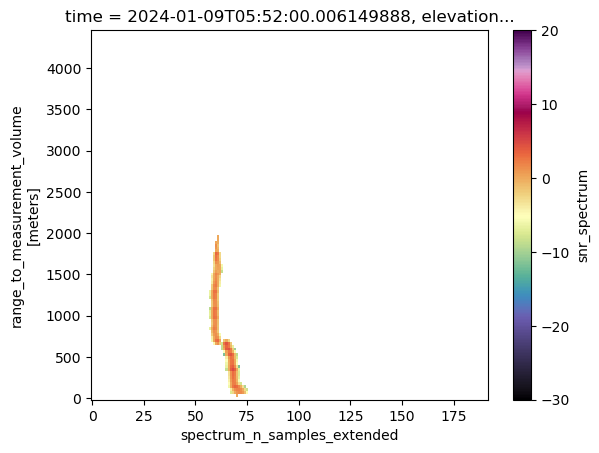

In [196]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T05:52:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.055200.snr.png', dpi=300, bbox_inches='tight')

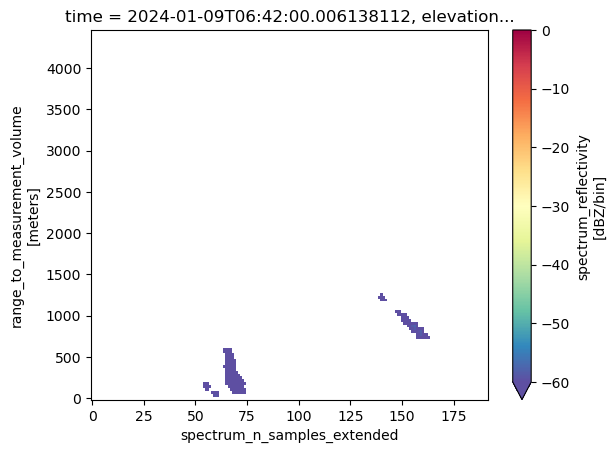

In [197]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T06:42:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.064200.png', dpi=300, bbox_inches='tight')

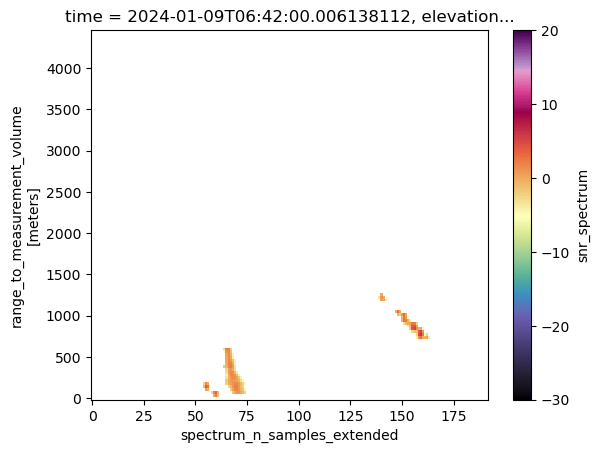

In [198]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T06:42:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.064200.snr.png', dpi=300, bbox_inches='tight')

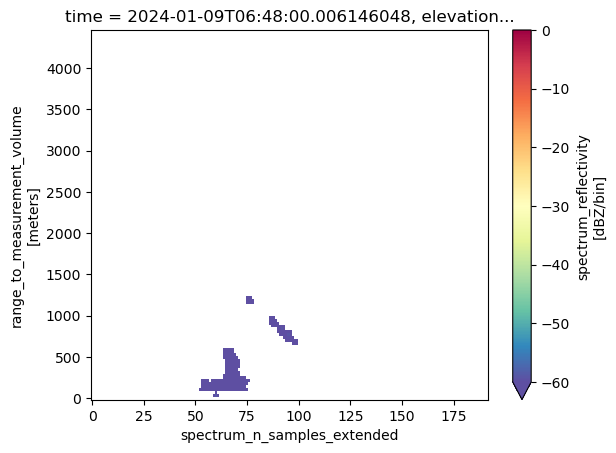

In [199]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T06:48:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.064800.png', dpi=300, bbox_inches='tight')

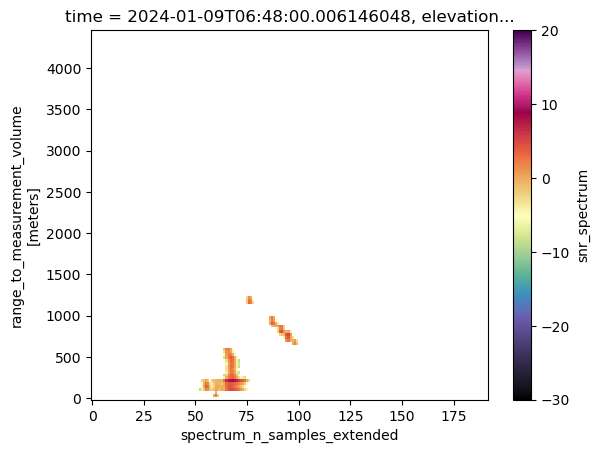

In [200]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T06:48:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.064800.snr.png', dpi=300, bbox_inches='tight')

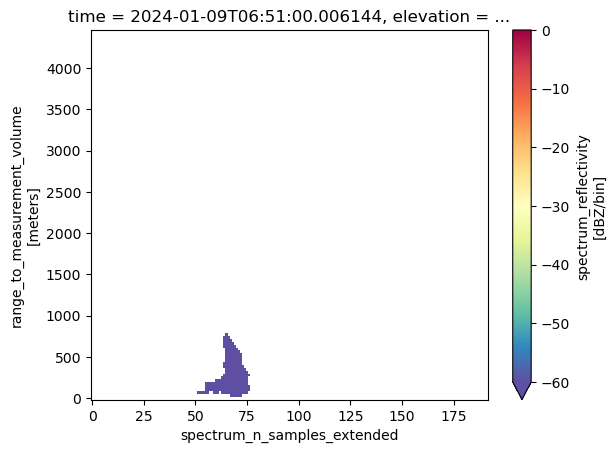

In [201]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T06:51:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.065100.png', dpi=300, bbox_inches='tight')

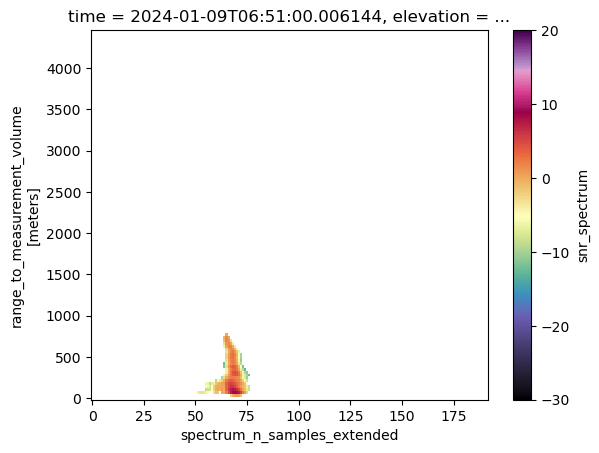

In [202]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T06:51:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.065100.snr.png', dpi=300, bbox_inches='tight')

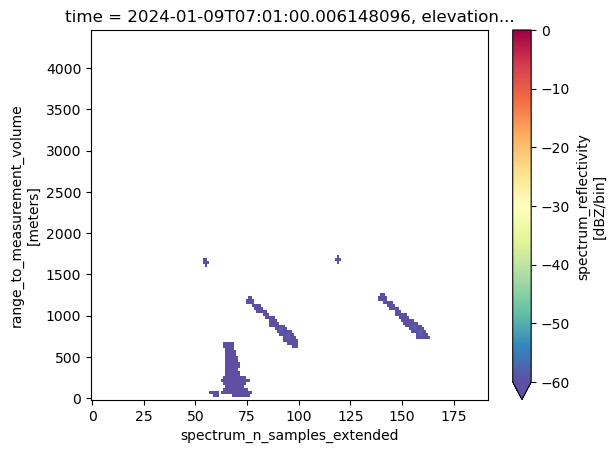

In [203]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T07:01:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.070100.png', dpi=300, bbox_inches='tight')

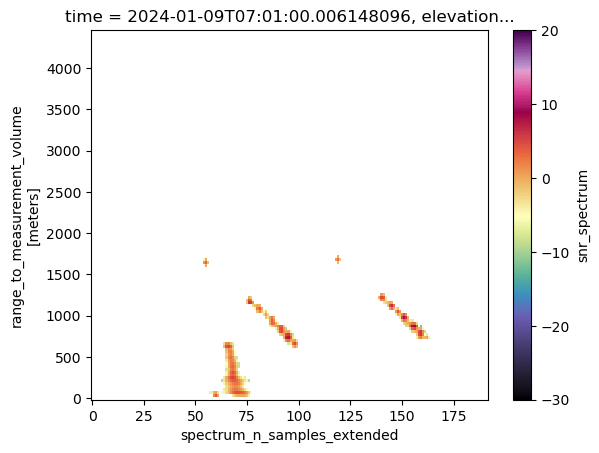

In [204]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T07:01:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.070100.snr.png', dpi=300, bbox_inches='tight')

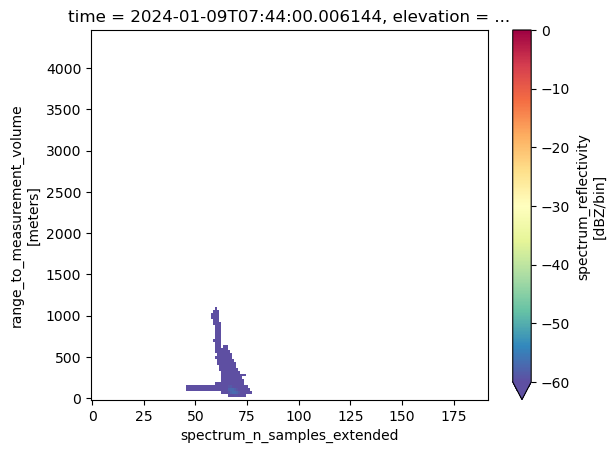

In [205]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T07:44:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.074400.png', dpi=300, bbox_inches='tight')

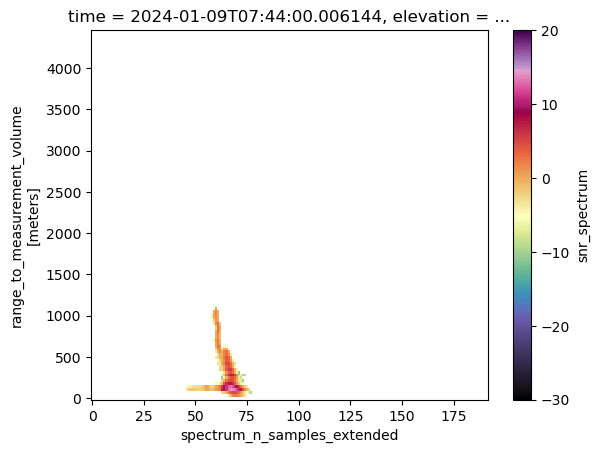

In [206]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T07:44:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.074400.snr.png', dpi=300, bbox_inches='tight')

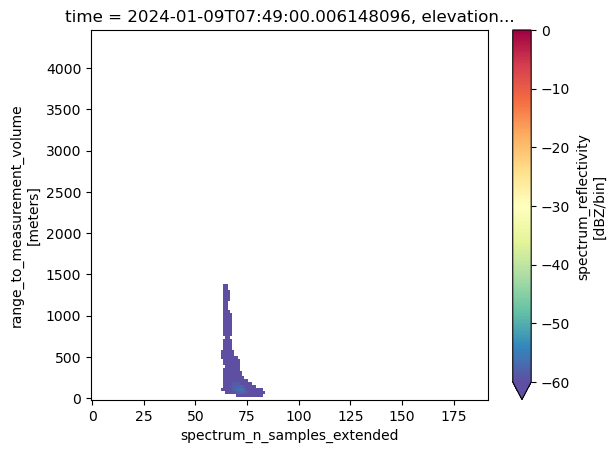

In [207]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T07:49:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.074900.png', dpi=300, bbox_inches='tight')

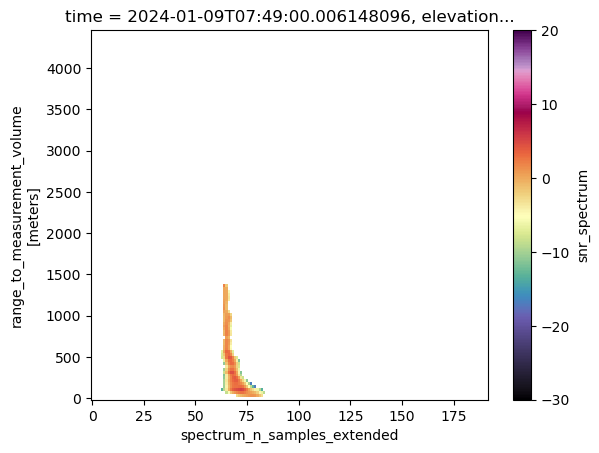

In [208]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T07:49:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.074900.snr.png', dpi=300, bbox_inches='tight')

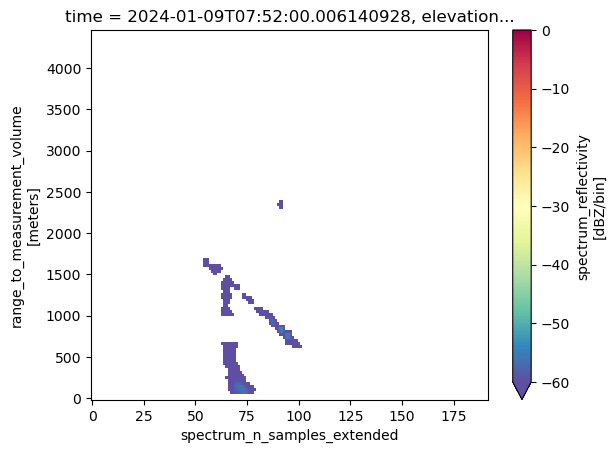

In [209]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T07:52:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.075200.png', dpi=300, bbox_inches='tight')

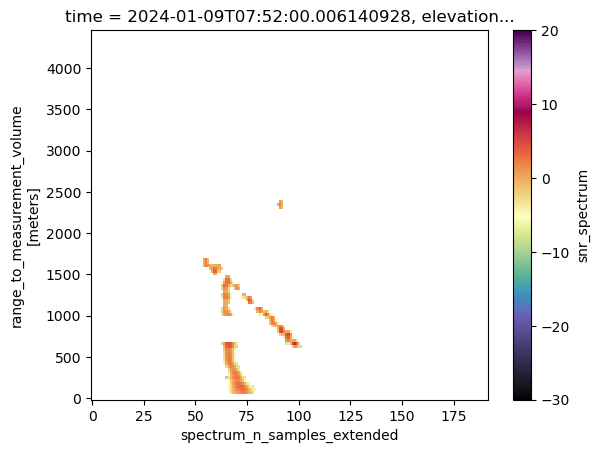

In [210]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T07:52:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.075200.snr.png', dpi=300, bbox_inches='tight')

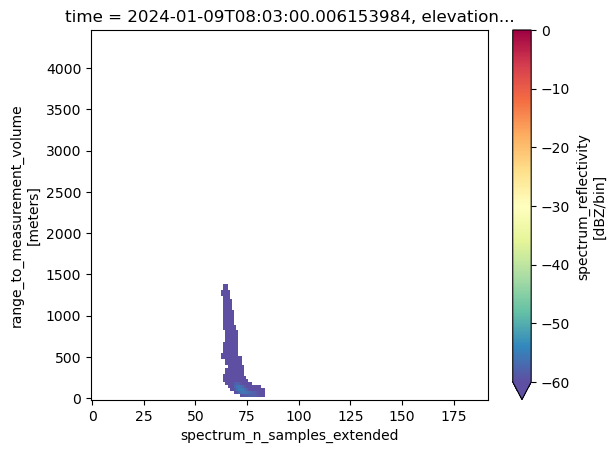

In [211]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T08:03:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.080300.png', dpi=300, bbox_inches='tight')

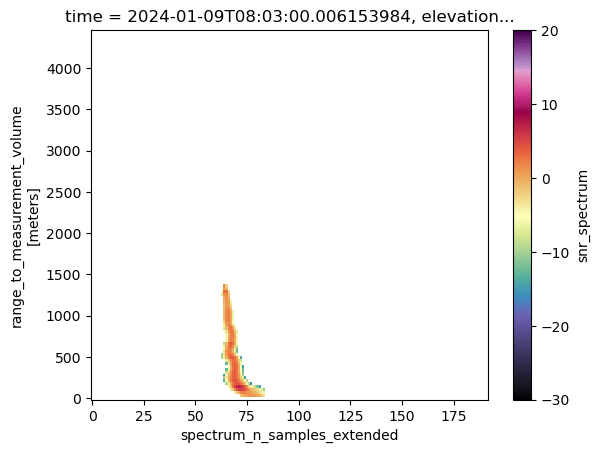

In [212]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T08:03:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.080300.snr.png', dpi=300, bbox_inches='tight')

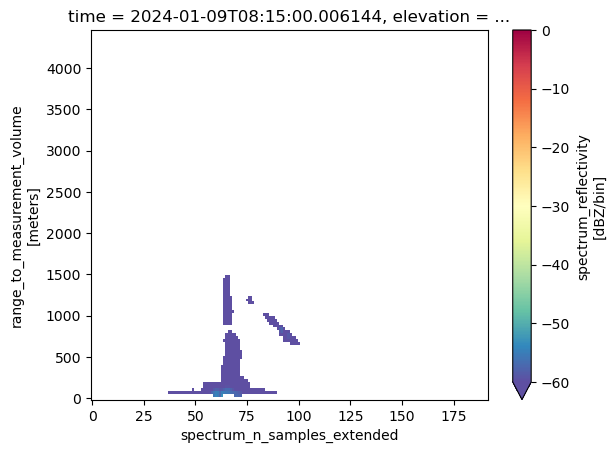

In [213]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T08:15:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.081500.png', dpi=300, bbox_inches='tight')

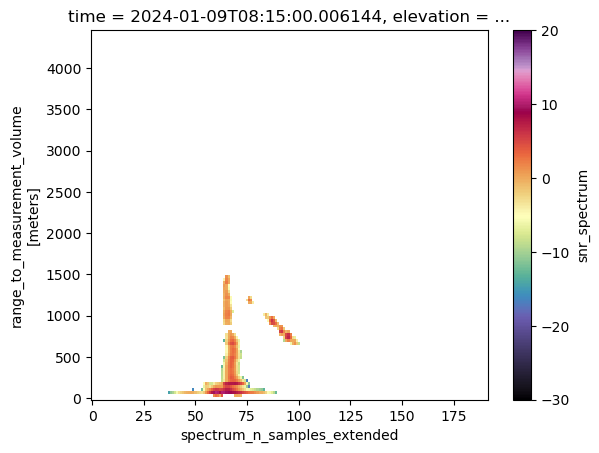

In [214]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T08:15:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.081500.snr.png', dpi=300, bbox_inches='tight')

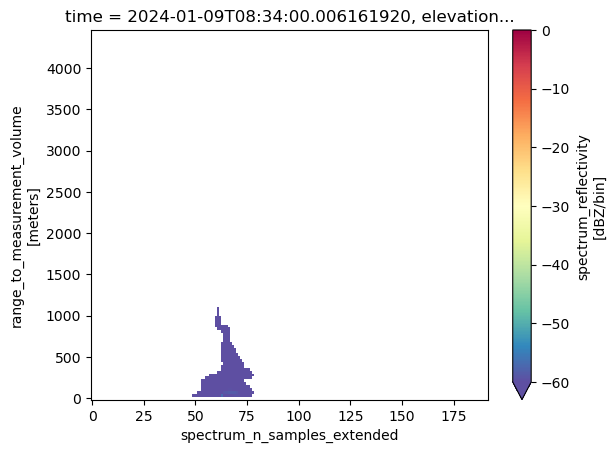

In [215]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T08:34:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.083400.png', dpi=300, bbox_inches='tight')

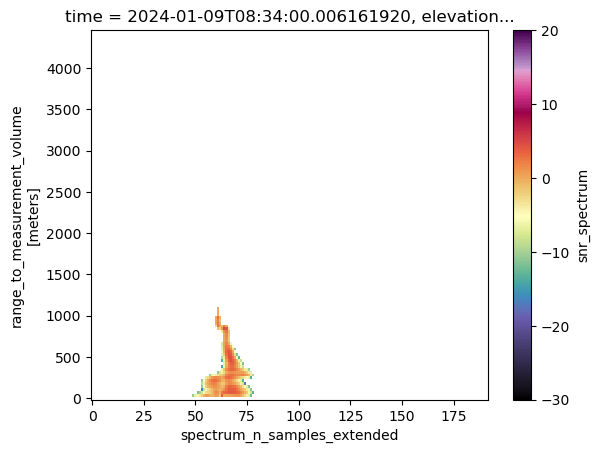

In [216]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T08:34:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.083400.snr.png', dpi=300, bbox_inches='tight')

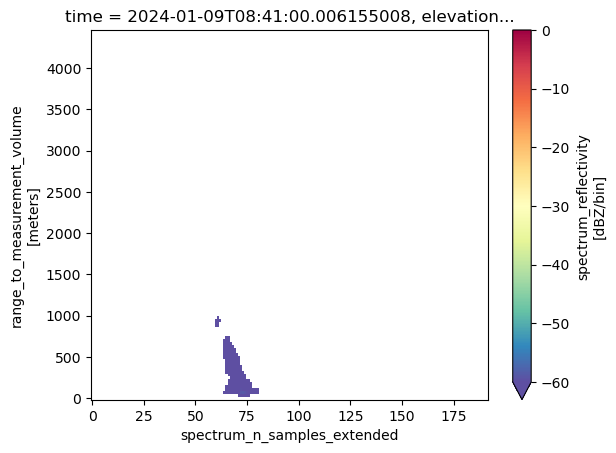

In [217]:
ds['spectrum_reflectivity'].sel(time='2024-01-09T08:41:00').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240109.084100.png', dpi=300, bbox_inches='tight')

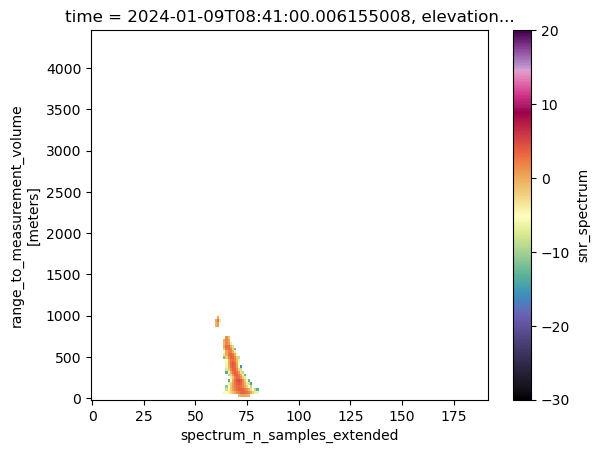

In [218]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-09T08:41:00').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240109.084100.snr.png', dpi=300, bbox_inches='tight')

In [8]:
ds = xr.open_mfdataset('/nfs/gce/projects/crocus/data/early_in_project_ingested_data/neiu-mrrpro/processed/202401/20240112/*.nc')
ds['range_spectra'] = (['n_spectra'], ds['range'].values)
ds = ds.set_coords(['range_spectra'])

In [9]:
ds

<xarray.Dataset>
Dimensions:                       (time: 8280, range: 128,
                                   spectrum_n_samples_extended: 192,
                                   spectrum_n_samples: 64, n_spectra: 128)
Coordinates:
  * range                         (range) float32 0.0 35.0 ... 4.445e+03
  * time                          (time) datetime64[ns] 2024-01-12T00:00:00.0...
    elevation                     (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    azimuth                       (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    range_spectra                 (n_spectra) float32 0.0 35.0 ... 4.445e+03
Dimensions without coordinates: spectrum_n_samples_extended,
                                spectrum_n_samples, n_spectra
Data variables:
    spectrum_reflectivity         (time, range, spectrum_n_samples_extended) float64 dask.array<chunksize=(1, 128, 192), meta=np.ndarray>
    Zea                           (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    VEL                           (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    WIDTH                         (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    SNR                           (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    noise_level                   (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    noise_floor                   (time, range) float64 dask.array<chunksize=(1, 128), meta=np.ndarray>
    flag_spectrum_reconstruction  (time, range, spectrum_n_samples) float64 dask.array<chunksize=(1, 128, 64), meta=np.ndarray>
Attributes:
    Conventions:      CF/Radial
    version:          1.3
    title:            METEK MRR Pro 1.2.5 Data - Re-processed with ASPRO
    institution:      
    references:       
    source:           
    history:          Re-processed with ASPRO on 25/03/2024 19:56:35 UTC
    comment:          
    instrument_name:  METEK MRR Pro 1.2.5, ID: MRRPro97, METEK Serial Number:...
    site_name:        cms-mrr-002
    field_names:      spectrum_reflectivity,Zea,VEL,WIDTH,SNR,noise_level,noi...

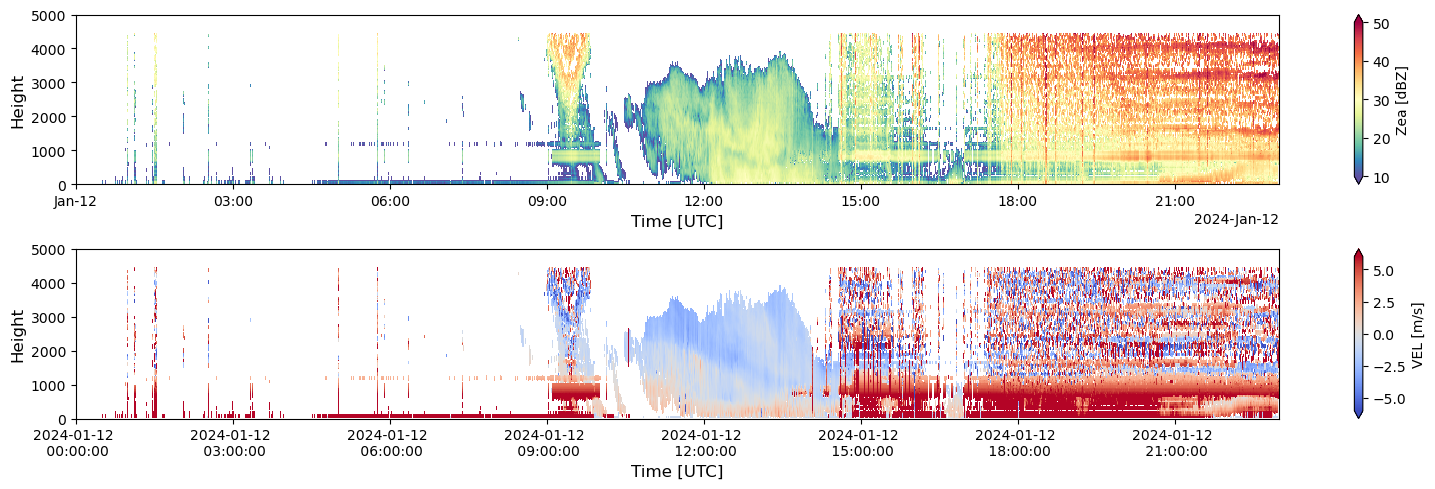

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(16, 5))
ds["Zea"].T.plot(cmap='Spectral_r', vmin=10, vmax=50, ax=ax[0])
ax[0].set_xlabel('Time [UTC]', fontsize=12), ax[0].set_ylabel('Height', fontsize=12)
ax[0].set_ylim(0, 5000)
ds["VEL"].T.plot(cmap='coolwarm', vmin=-6, vmax=6, ax=ax[1])
ax[1].set_xlabel('Time [UTC]', fontsize=12), ax[1].set_ylabel('Height', fontsize=12)
ax[1].set_ylim(0, 5000)
date_form = DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)
fig.tight_layout()
#plt.savefig('January 12th Processed 2.png', dpi=300, bbox_inches='tight')

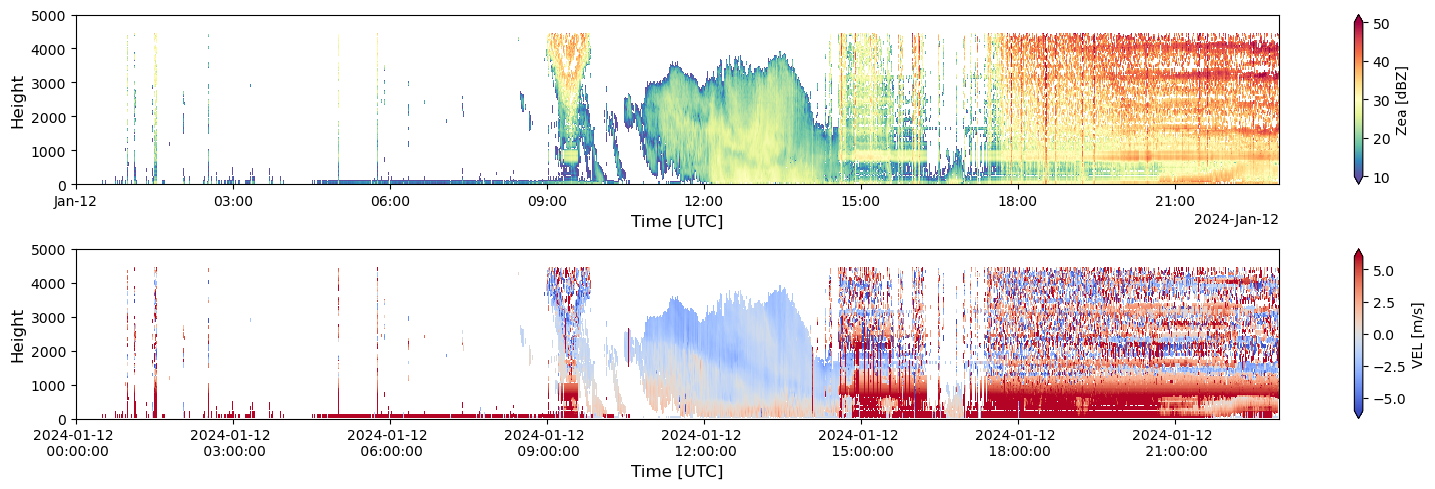

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(16, 5))
ds["Zea"].T.plot(cmap='Spectral_r', vmin=10, vmax=50, ax=ax[0])
ax[0].set_xlabel('Time [UTC]', fontsize=12), ax[0].set_ylabel('Height', fontsize=12)
ax[0].set_ylim(0, 5000)
ds["VEL"].T.plot(cmap='coolwarm', vmin=-6, vmax=6, ax=ax[1])
ax[1].set_xlabel('Time [UTC]', fontsize=12), ax[1].set_ylabel('Height', fontsize=12)
ax[1].set_ylim(0, 5000)
date_form = DateFormatter("%Y-%m-%d \n %H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_form)
fig.tight_layout()
plt.savefig('January 12th Processed 3.png', dpi=300, bbox_inches='tight')

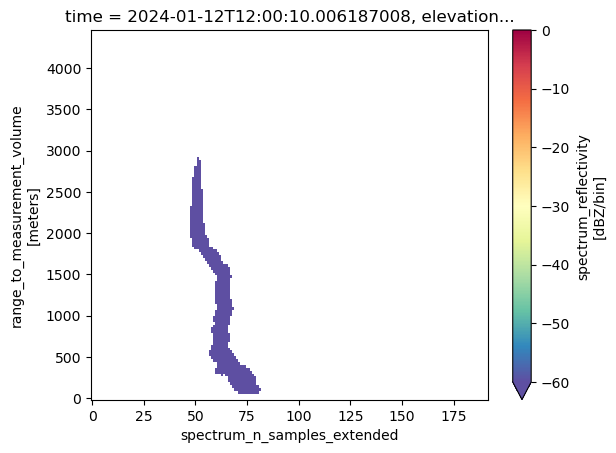

In [221]:
ds['spectrum_reflectivity'].sel(time='2024-01-12T12:00:10').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240112.120010.png', dpi=300, bbox_inches='tight')

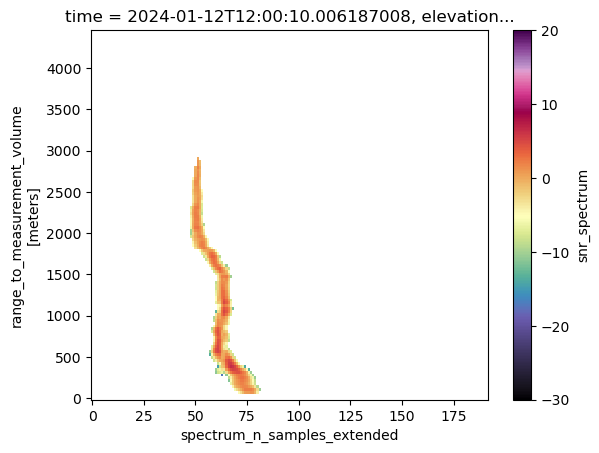

In [222]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-12T12:00:10').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240112.120010.snr.png', dpi=300, bbox_inches='tight')

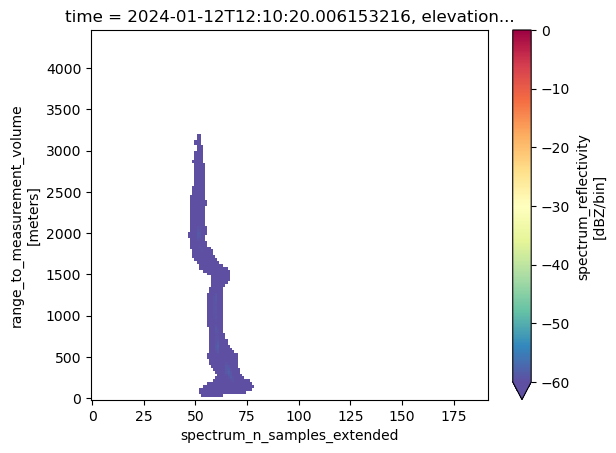

In [223]:
ds['spectrum_reflectivity'].sel(time='2024-01-12T12:10:20').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240112.121020.png', dpi=300, bbox_inches='tight')

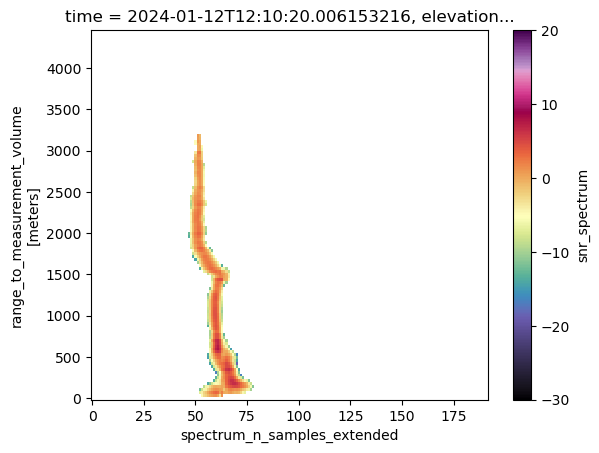

In [224]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-12T12:10:20').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240112.121020.snr.png', dpi=300, bbox_inches='tight')

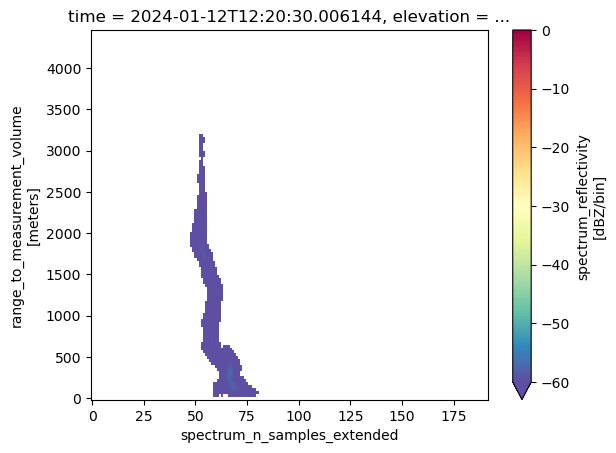

In [225]:
ds['spectrum_reflectivity'].sel(time='2024-01-12T12:20:30').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240112.122030.png', dpi=300, bbox_inches='tight')

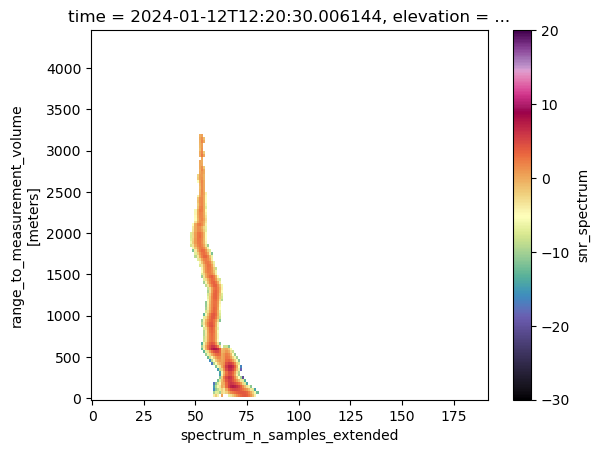

In [226]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-12T12:20:30').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240112.122030.snr.png', dpi=300, bbox_inches='tight')

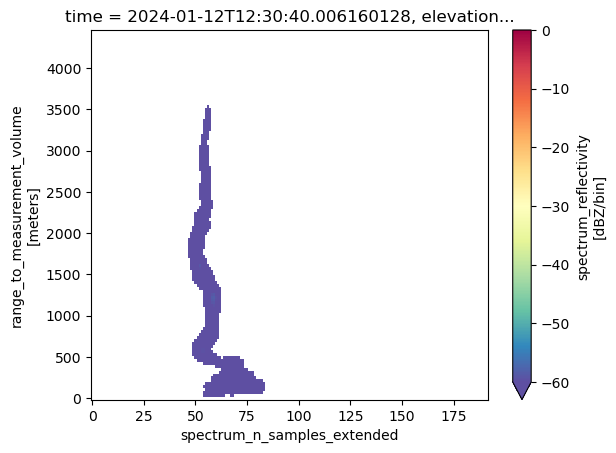

In [227]:
ds['spectrum_reflectivity'].sel(time='2024-01-12T12:30:40').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240112.123040.png', dpi=300, bbox_inches='tight')

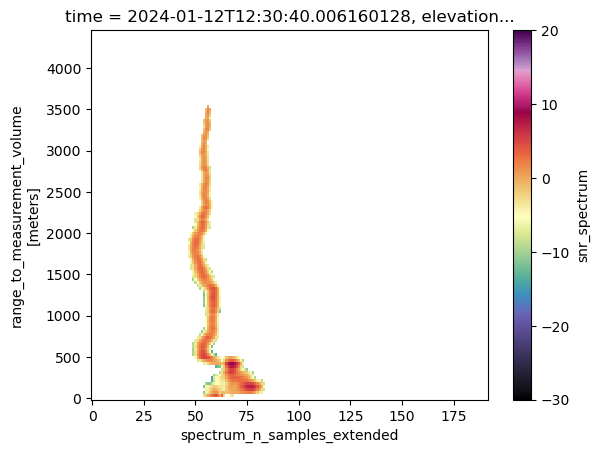

In [231]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-12T12:30:40').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240112.123040.snr.png', dpi=300, bbox_inches='tight')

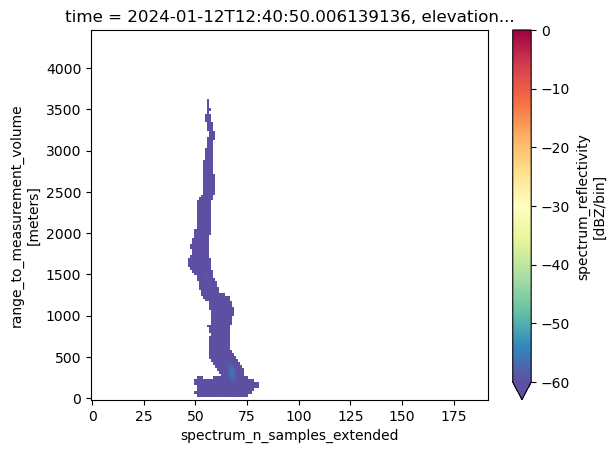

In [229]:
ds['spectrum_reflectivity'].sel(time='2024-01-12T12:40:50').plot(cmap='Spectral_r', vmin=-60, vmax=0)
plt.savefig('20240112.124050.png', dpi=300, bbox_inches='tight')

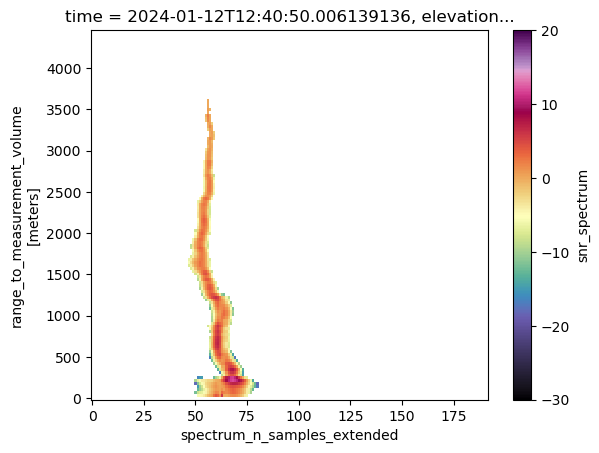

In [230]:
ds['snr_spectrum'] = 10**(ds['spectrum_reflectivity']/10) / 10**(ds['spectrum_reflectivity'].median(dim='spectrum_n_samples_extended')/10)
ds['snr_spectrum'] = 10 * np.log10(ds['snr_spectrum'])
ds['snr_spectrum'].sel(time='2024-01-12T12:40:50').plot(cmap='ChaseSpectral', vmin=-30, vmax=20)
plt.savefig('20240112.124050.snr.png', dpi=300, bbox_inches='tight')